# Explaining Relationships Using Regression Analysis

A regression model can be used for two different purposes. It can be used to explain how one variable (y) depends on another variable (x). Indeed, here we are often trying to identify *causal* inferences, to explain how a system works. It can also be used to make *forecasts* about future outcomes. 

During this week we are going to focus on the first purpose, thinking about potential causal links in the performance of professional sports teams. We are going to focus on the performance of teams across an entire season, in terms of either win percentage or league position.

The main input to any team is, of course, the players themselves. Teams compete to hire the best players and player agents seek to find the best financial deal for their clients. It is reasonable to expect, therefore, that team expenditure on player salaries should be an important factor in determining team performance. To be clear, the logic of this is NOT that paying higher salaries will make players perform better. At the top level of professional sports, all players are highly motivated, and salary probably does not play a significant motivational role. Rather, competition for players means that salaries are likely to reflect relative abilities. Better players command higher salaries, and as a result the aggregate pay of players on the team is likely to be a good predictor of team performance.

There are a number of sources for player salary data. In the North American major leagues, salary negotiations are framed by collective bargaining agreements with player unions, which often publish individual player salary data. In European soccer leagues, aggregate salary data is to be found in audited financial statements of professional clubs, which are often available to the public (notably in England). Cricket players in the Indian Premier League have their salaries determined in a public auction. 

This week we are going to examine the wage-performance relationship in four different leagues - the NBA, the English Premier League, Major League Baseball and the National Hockey League. While our focus is on the role of salaries, we will also consider other factors that might be relevant, which will help us to think about some of the issues that arise in regression analysis.

We start with the NBA.

In [1]:
# As usual, we begin by loading the packages we will need

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.formula.api as smf

In [4]:
# Now we load the data

NBA=pd.read_excel("D:\\GitHub\\Coursera\\SportsPerformanceAnalytics\\FoundationsofSportsAnalytics_DataRepresentationanModelsinSports\\data\\Week5\\NBA pay and performance.xlsx")
NBA

,Team,season,wpc,salaries
0,Atlanta Hawks,2012,0.606,55503683
1,Atlanta Hawks,2013,0.537,60437642
2,Atlanta Hawks,2014,0.463,58841508
3,Atlanta Hawks,2015,0.732,62487671
4,Atlanta Hawks,2016,0.585,82337675
...,...,...,...,...
205,Washington Wizards,2014,0.537,66615345
206,Washington Wizards,2015,0.561,74590100
207,Washington Wizards,2016,0.500,83380073
208,Washington Wizards,2017,0.598,105042249


We use .describe() to look at the summary statistics for the data. From this we can see that we have 210 observations, for teams running from 2012 to 2018 (7 seasons). Our two variables of interest are win percentage and team salaries. We can also use .info() to summarize the dataframe.

In [3]:
NBA.describe()

,season,wpc,salaries
count,210.000000,210.000000,2.100000e+02
mean,2015.000000,0.497843,7.825339e+07
std,2.004779,0.154052,2.523282e+07
min,2012.000000,0.106000,2.893890e+07
25%,2013.000000,0.378000,5.937660e+07
50%,2015.000000,0.512000,7.372819e+07
75%,2017.000000,0.606000,9.564297e+07
max,2018.000000,0.890000,1.425601e+08


In [5]:
NBA.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 210 entries, 0 to 209
Data columns (total 4 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   Team      210 non-null    object 
 1   season    210 non-null    int64  
 2   wpc       210 non-null    float64
 3   salaries  210 non-null    int64  
dtypes: float64(1), int64(2), object(1)
memory usage: 6.7+ KB


If salaries reflect player ability, then the the success of a team should depend on how much more or less it pays than its rivals. However, if we look at salaries paid out in different seasons, there is clearly inflation in player salaries. We can see this if we use the .groupby() command to look at total salaries over the seven seasons:

In [6]:
Sumsal = NBA.groupby(['season'])['salaries'].sum().reset_index().rename(columns={'salaries':'allsal'})
Sumsal

,season,allsal
0,2012,1438650614
1,2013,1837810750
2,2014,1976549213
3,2015,2153667904
4,2016,2523411764
5,2017,3159860863
6,2018,3343261288


We can see that salaries in 2018 were more than double the level in 2012, and increased consistently from year to year. This does not imply that the players were gettign better from season to season. Rather, this is a reflection of the growing revenues of the NBA, and the ability of players to bargain for a more or less constant share of this growing revenue. 

So, if we now want to account for team performance in terms of salaries, we need to make sure we compare like with like. What $1 million would buy in 2012 was not the same as what it would buy in 2018. It's easy to adjust for this. We simply divide the salary of each team in each season by the total spending of all teams in that season, so that we have a measure of salary spending relative to the competition.

To do this we first use pd.merge() to add the aggregate salaries for each season to our original dataframe:

In [7]:
NBA = pd.merge(NBA, Sumsal, on=['season'], how='left')
display(NBA)

,Team,season,wpc,salaries,allsal
0,Atlanta Hawks,2012,0.606,55503683,1438650614
1,Atlanta Hawks,2013,0.537,60437642,1837810750
2,Atlanta Hawks,2014,0.463,58841508,1976549213
3,Atlanta Hawks,2015,0.732,62487671,2153667904
4,Atlanta Hawks,2016,0.585,82337675,2523411764
...,...,...,...,...,...
205,Washington Wizards,2014,0.537,66615345,1976549213
206,Washington Wizards,2015,0.561,74590100,2153667904
207,Washington Wizards,2016,0.500,83380073,2523411764
208,Washington Wizards,2017,0.598,105042249,3159860863


We can now create a variable which we call 'relsal', which measures the share of team's salary spend in the total spending of all teams in that season:

In [8]:
NBA['relsal']= NBA['salaries']/NBA['allsal']

Before running a regression, it makes sense to look at the relationship between salaries and win percentage on a chart. To do this we use sns.reglot(). Since our argument is that higher relative salaries mean better players which in turns leads to more wins, we put relsal on the x axis and wpc on the y axis.

<AxesSubplot:xlabel='relsal', ylabel='wpc'>

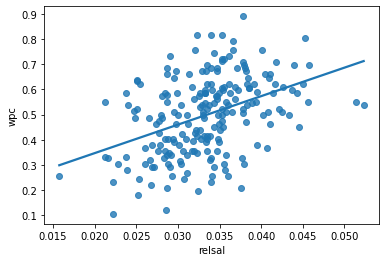

In [9]:
sns.regplot(x="relsal", y="wpc", data = NBA, ci=False)

It's clear from the data that there is a positive correlation between relsal and wpc, as shown by the regression line which regplot adds to the scatter diagram. We now run a regression using smf.ols() in order to derive the coefficients of the regression and other diagnostic statistics. 

In [10]:
wpcsal1_lm = smf.ols(formula = 'wpc ~ relsal', data=NBA).fit()
print(wpcsal1_lm.summary())

                            OLS Regression Results                            
Dep. Variable:                    wpc   R-squared:                       0.172
Model:                            OLS   Adj. R-squared:                  0.168
Method:                 Least Squares   F-statistic:                     43.26
Date:                Tue, 01 Nov 2022   Prob (F-statistic):           3.81e-10
Time:                        14:30:35   Log-Likelihood:                 115.16
No. Observations:                 210   AIC:                            -226.3
Df Residuals:                     208   BIC:                            -219.6
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      0.1211      0.058      2.086      0.0

The first things to look at in any regression are the coefficients of the explanatory variables and their statistical significance. We can see here that the coefficient on relsal is 11.3009. This means that every one percentage (0.01) increase in the share of the team in total salaries leads to and 11.3 x .01 increase in win percentage - that is roughly .11 , or eleven percentage points. That is a very large increase, but not that the share of salaries, as can be seen on the x axis of the chart above, ranges from around .02 (2%) to .05 (5%). Thus going from the lowest salary to the highest share (from 2% to 5%) will produce a 3 x .11 = .33 increase in win percentage - from around roughly 33% to 66%. 

This estimate is statistically significant. The coefficient estimate is more than six times larger than its standard error (this ratio is called the t- statistic (6.577). The p-value (P>|t|) tells us the probability of observing such estimate if the true value were actually zero. The p-value here is shown as "0.000" - however, it can never be exactly zero. It is just that, in this case, it is so small that is does not register up to three decmial places. The usual standard for statistical significance is a p-value below 0.05. Clearly, in this case the estimate clearly beats that standard.

How much of the variation in team performance is captured by this relsal? We can see this from the R-squared coefficient which is 0.172, or 17.2%. Clearly, there is much else to team performance than salaries alone.

Is the coefficient estimate plausible? Our regression estimate is the best estimate we have of the effect, but *only under the assumption that our regression includes all of the relevant variables*. If there are other variables which influence performance other than salary share, then our regression estimate will be biased, either upward or downward. This is the problem known as "omitted variable bias" (OVB). There is no way to be certain that OVB is not a problem, it requires good judgment and careful thought to decide on whether there are other variables that should be included.

The fact that the R-squared value was only 0.172 might give one to think that there are other factors to include, but it is always possible that the remainder is just random - the effect of luck, which no doubt plays a role in every game.

But in this case, it is possible to think of other factors that might be relevant and therefore should be included. One such is "lagged dependent variable", which here means the value of win percentage in the previous season. While the salary level should capture many aspects of team quality, salaries are not renegotiated every year, and many aspects of team quality would have been in pace in the previous season. So we can add this lagged dependent variable to our regression, and then see if this changes our estimate of the impact of salaries.

We create this variable in two stages. First, we sort the data by team, and then by season, using .sort_values()

## Self test

Based on this model, what would be the win percentage of a team for whom the value of relsal was 4%?

In [11]:
NBA.sort_values(by=['Team','season'], ascending=True)

,Team,season,wpc,salaries,allsal,relsal
0,Atlanta Hawks,2012,0.606,55503683,1438650614,0.038580
1,Atlanta Hawks,2013,0.537,60437642,1837810750,0.032886
2,Atlanta Hawks,2014,0.463,58841508,1976549213,0.029770
3,Atlanta Hawks,2015,0.732,62487671,2153667904,0.029015
4,Atlanta Hawks,2016,0.585,82337675,2523411764,0.032630
...,...,...,...,...,...,...
205,Washington Wizards,2014,0.537,66615345,1976549213,0.033703
206,Washington Wizards,2015,0.561,74590100,2153667904,0.034634
207,Washington Wizards,2016,0.500,83380073,2523411764,0.033043
208,Washington Wizards,2017,0.598,105042249,3159860863,0.033243


Second, we create the lagged value of wpc. This done by using .groupby() together with .shift(1). The value 1 in .shift() signifies the value is for the previous season that is being added to each row. If we used .shift(2) it would add the value from 2 seasons before, and so on.

Note that because we define the lagged value to apply to each team, there is a missing value (NaN) for each team in 2012, which is the first year in our data.

In [12]:
NBA['wpc_lag'] = NBA.groupby('Team')['wpc'].shift(1)
NBA

,Team,season,wpc,salaries,allsal,relsal,wpc_lag
0,Atlanta Hawks,2012,0.606,55503683,1438650614,0.038580,NaN
1,Atlanta Hawks,2013,0.537,60437642,1837810750,0.032886,0.606
2,Atlanta Hawks,2014,0.463,58841508,1976549213,0.029770,0.537
3,Atlanta Hawks,2015,0.732,62487671,2153667904,0.029015,0.463
4,Atlanta Hawks,2016,0.585,82337675,2523411764,0.032630,0.732
...,...,...,...,...,...,...,...
205,Washington Wizards,2014,0.537,66615345,1976549213,0.033703,0.354
206,Washington Wizards,2015,0.561,74590100,2153667904,0.034634,0.537
207,Washington Wizards,2016,0.500,83380073,2523411764,0.033043,0.561
208,Washington Wizards,2017,0.598,105042249,3159860863,0.033243,0.500


In [13]:
# this command allows us to see all rows in the window

pd.set_option('display.max_rows', 250)
NBA

,Team,season,wpc,salaries,allsal,relsal,wpc_lag
0,Atlanta Hawks,2012,0.606,55503683,1438650614,0.038580,NaN
1,Atlanta Hawks,2013,0.537,60437642,1837810750,0.032886,0.606
2,Atlanta Hawks,2014,0.463,58841508,1976549213,0.029770,0.537
3,Atlanta Hawks,2015,0.732,62487671,2153667904,0.029015,0.463
4,Atlanta Hawks,2016,0.585,82337675,2523411764,0.032630,0.732
5,Atlanta Hawks,2017,0.524,105882053,3159860863,0.033508,0.585
6,Atlanta Hawks,2018,0.293,97118111,3343261288,0.029049,0.524
7,Boston Celtics,2012,0.591,56768577,1438650614,0.039460,NaN
8,Boston Celtics,2013,0.506,69572590,1837810750,0.037856,0.591
9,Boston Celtics,2014,0.305,70105837,1976549213,0.035469,0.506


We now run our regression again, but adding wpc_lag into the regression equation:

In [14]:
wpcsal2_lm = smf.ols(formula = 'wpc ~wpc_lag + relsal', data=NBA).fit()
print(wpcsal2_lm.summary())

                            OLS Regression Results                            
Dep. Variable:                    wpc   R-squared:                       0.416
Model:                            OLS   Adj. R-squared:                  0.410
Method:                 Least Squares   F-statistic:                     62.78
Date:                Tue, 01 Nov 2022   Prob (F-statistic):           2.64e-21
Time:                        14:35:36   Log-Likelihood:                 129.13
No. Observations:                 179   AIC:                            -252.3
Df Residuals:                     176   BIC:                            -242.7
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      0.1293      0.054      2.374      0.0

The result of this change is quite dramatic. Not only has the coefficient on relsal fallen to only 2.0165, but it is not statistically insignificant (p_value is 0.28, greater than the critical value of .05). Last year's win percentage is highly significant and the R-squared of the regression has risen to 0.416. 

It is quite usual for the lagged dependent variable to be significant in situations such as these- history matters. But should we now abandon our theory that wages influence performance? One should also be cautious about a theory that relies only on the lagged dependent variable - while history matters, one should also expect there to be specific, quantifiable factors that drive history.

While the omission of the lagged dependent variable in the first regression suggests that there may have been OVB that biased the estimate upwards, there is also the possibility that OVB can bias the estimate downwards. 

Clearly, not all teams are identical, while our regression estimates thus far treat each team as if it were, in the sense that spending would affect the performance of each team in the same way, and that last year's win percentage would imact this year's in the same way. In our regression specification we want to find balance between treating each team as if it were identical, and treating each team as if it were completely unique. The truth is likely to be that there are common factors affecting all teams, but that there are also idiosyncrasies. This is often described as heterogeneity.

One way we can introduce heterogeneity is through fixed effects. Fixed effects are dummy variables. For each team there is a fixed effect, equal to one if the row relates to the team in question, and zero otherwise. Each team can have its own fixed effects. Estimation of fixed effects allows us to identify differences between the teams that are independent of the impact of salaries or of the lagged dependent variable.

Adding fixed effects is very easy in Python. The variable 'Team' identifies the team names, and if we add "C(Team)" to the regression formula Python will estimate a fixed effect for each team.

We now run the regression with the lagged dependent variable and fixed effects, to see what impact this has on the estimate of the salary coefficient.

## Self test

Based on this model, what would be the win percentage of a team that (a) had 0.5 win percentage last season and (b) had a value of relsal equal to 3%?

In [15]:
wpcsal3_lm = smf.ols(formula = 'wpc ~ wpc_lag + relsal +C(Team)', data=NBA).fit()
print(wpcsal3_lm.summary())

                            OLS Regression Results                            
Dep. Variable:                    wpc   R-squared:                       0.585
Model:                            OLS   Adj. R-squared:                  0.498
Method:                 Least Squares   F-statistic:                     6.686
Date:                Tue, 01 Nov 2022   Prob (F-statistic):           5.88e-16
Time:                        14:37:39   Log-Likelihood:                 159.66
No. Observations:                 179   AIC:                            -255.3
Df Residuals:                     147   BIC:                            -153.3
Df Model:                          31                                         
Covariance Type:            nonrobust                                         
                                        coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------------------------
Interc

There are 30 fixed effects listed in the output, one for each team. A positive fixed effect means that in some way the team was able to perform above average, and a negative fixed effect implies below average performance. However, most of the fixed effects are not statistically significant. The significant fixed effects are: The Brooklyn Nets (negative), the Golden State Warriors (positive), The LA Lakers (negative), Orlando Magic (negative), San Antonio Spurs (positive).

Looking at our main variable of interest, relsal, it is clear that this variable is once again statistically significant with the addition of the fixed effects. Thus, we might conclude that the absence of the fixed effects biased the coefficient estimate downwards. The coefficient is statistically significant at the 5% level, and the value of 4.9388 implies that increasing salary share in the NBA by 1 percentage point (e.g. from 2% to 3%) will lead to an increase in win percentage of almost 5%. This is smaller than our original estimate, but also because of the presence of the lagged dependent variable, spending which increases win percentage this season will also have an effect, albeit a smaller one, on the following season. Indeed, an increase in spending today will create a ripple effect which will be discernible in performance for a number of years into the future.

Also note that the size of the lagged dependent variable is smaller once we add the fixed effects. Finally, with this third specification the R-squared of the regression has now risen to 0.585 (close to 60%), which accounts for significant fraction of the overall variation. 

We should never expect to explain 100% of the variation of outcomes in sport - if we could do that then each game would be perfectly predictable - and then what would be the point of watching?

## Self test

Run the regression of win percentage on relsal with fixed effects but without the lagged depedent variable. Compare your output results. Compare this to the previous three regressions. Which do you think is the best representation of the data. Why?

# Conclusion

In this notebook we have explored the possibility of using regression analysis to explore the validity of a causal explanation of team success. That causal explanation was itself not derived from the data, but based on a theory that player quality will be reflected in salaries and therefore salaries will predict team success.

You might be wondering about why this works at all with the NBA, since the league operates a salary cap system which is intended to equalize resources among the teams. If each team spent the same amount of money on players, our theory predicts that each team can expect to win 50% of its games, and team performances will vary randomly around this mean. However, the NBA cap is a "soft cap", meaning that there are many exemptions, so teams spend varying amounts in reality. Some leagues, such as the NFL, operate a hard cap, which strictly prohibit spending above the cap. The NFL also has a salary floor, which prevents teams from spending a lot less than average. When looking at NFL data, therefore, it is much harder to identifty the effect of wage spending on performance. 

We next turn to look at the salary performance relationship in the English Premier League. 
